In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import warnings
warnings.filterwarnings("ignore")

import acgan
import acgan.model.gmm_gan
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import twodlearn as tdl
import tensorflow as tf
import tensorflow_datasets as tfds
from functools import reduce
import matplotlib.pyplot as plt
import datetime
BATCH_SIZE = 16
#acgan.data.DATA_DIR = '/data/marinodl/tensorflow_datasets'

In [2]:
session = tf.InteractiveSession()

In [3]:
print(datetime.datetime.now())

2019-09-04 19:16:50.818009


In [4]:
dataset = acgan.data.load_celeb_a_128_cropped(BATCH_SIZE)
#dataset = acgan.data.load_mnist32(BATCH_SIZE)
input_shape = dataset.output_shapes.as_list()
print('input shape: {}'.format(input_shape))

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


input shape: [None, 128, 128, 3]


In [5]:
import twodlearn.debug
@tdl.debug.stop_at_error
def _test():
    model = acgan.model.gmm_gan.GmmGan(
        embedding_size=512,
        embedding={'n_components': 10},
        encoder={'units':[256, 512, 512, 512], #1024
                 'kernels':3,
                 'strides':2},
        generator={'init_shape':(4, 4, 512),
                   'units': [256, 128, 64, 32, 16],
                   'outputs': 3,
                   'kernels': 3,
                   'strides': 2},
        discriminator={'units':[32, 64, 128, 256, 512], #1024
                       'kernels':3,
                       'strides':2,
                       'dropout':None}
    )
    return model
model = _test()
#model.noise_rate.init(rate=0.001)
print('output shape: {}'.format(
    model.generator.compute_output_shape(
        input_shape=[None, 100])))

output shape: (?, 128, 128, 3)


In [6]:
iter = dataset.make_one_shot_iterator()
xreal = iter.get_next()

import twodlearn.debug
@tdl.debug.stop_at_error
def _test():
    gen = model.generator_trainer(
        BATCH_SIZE,
        optimizer={'learning_rate': 0.001, 'beta1': 0.0}
        # pyramid_loss={'scale': 1e-6},
        # regularizer={'scale': 1e-6}
        )
        #regularizer={'scale': 1e-5})
    dis = model.discriminator_trainer(
        BATCH_SIZE, xreal=xreal, 
        optimizer={'learning_rate': 0.001, 'beta1': 0.0}
        # regularizer={'scale': 1e-6}
        )
        #regularizer={'scale': 1e-5})
    enc = model.encoder_trainer(
        BATCH_SIZE,
        optimizer={'learning_rate': 0.001, 'beta1': 0.0}
        )
    tdl.core.variables_initializer(gen.variables).run()
    tdl.core.variables_initializer(dis.variables).run()
    tdl.core.variables_initializer(enc.variables).run()
    return gen, dis, enc
gen, dis, enc = _test()


Instructions for updating:
Use tf.random.categorical instead.


Instructions for updating:
Use tf.random.categorical instead.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


In [57]:
print('step {} | dis {} | gen {}'.format(dis.train_step.eval(), dis.loss.eval(), gen.loss.eval()) )

step 663 | dis 0.6961484551429749 | gen 0.521915853023529


In [181]:
#for trial in tqdm.tqdm(range(2)):
acgan.train.run_training(dis=dis, gen=gen, n_steps=200, n_logging=10)
for i in tqdm.tqdm(range(200)):
    session.run(enc.step['encoder'])
for i in tqdm.tqdm(range(20)):
    session.run(enc.step['embedding'])

step(d/g) 4852/8848 | dis 0.4553 | gen 1.5293 : : 402it [01:34,  4.26it/s]                       
100%|██████████| 20/20 [00:02<00:00,  7.62it/s]


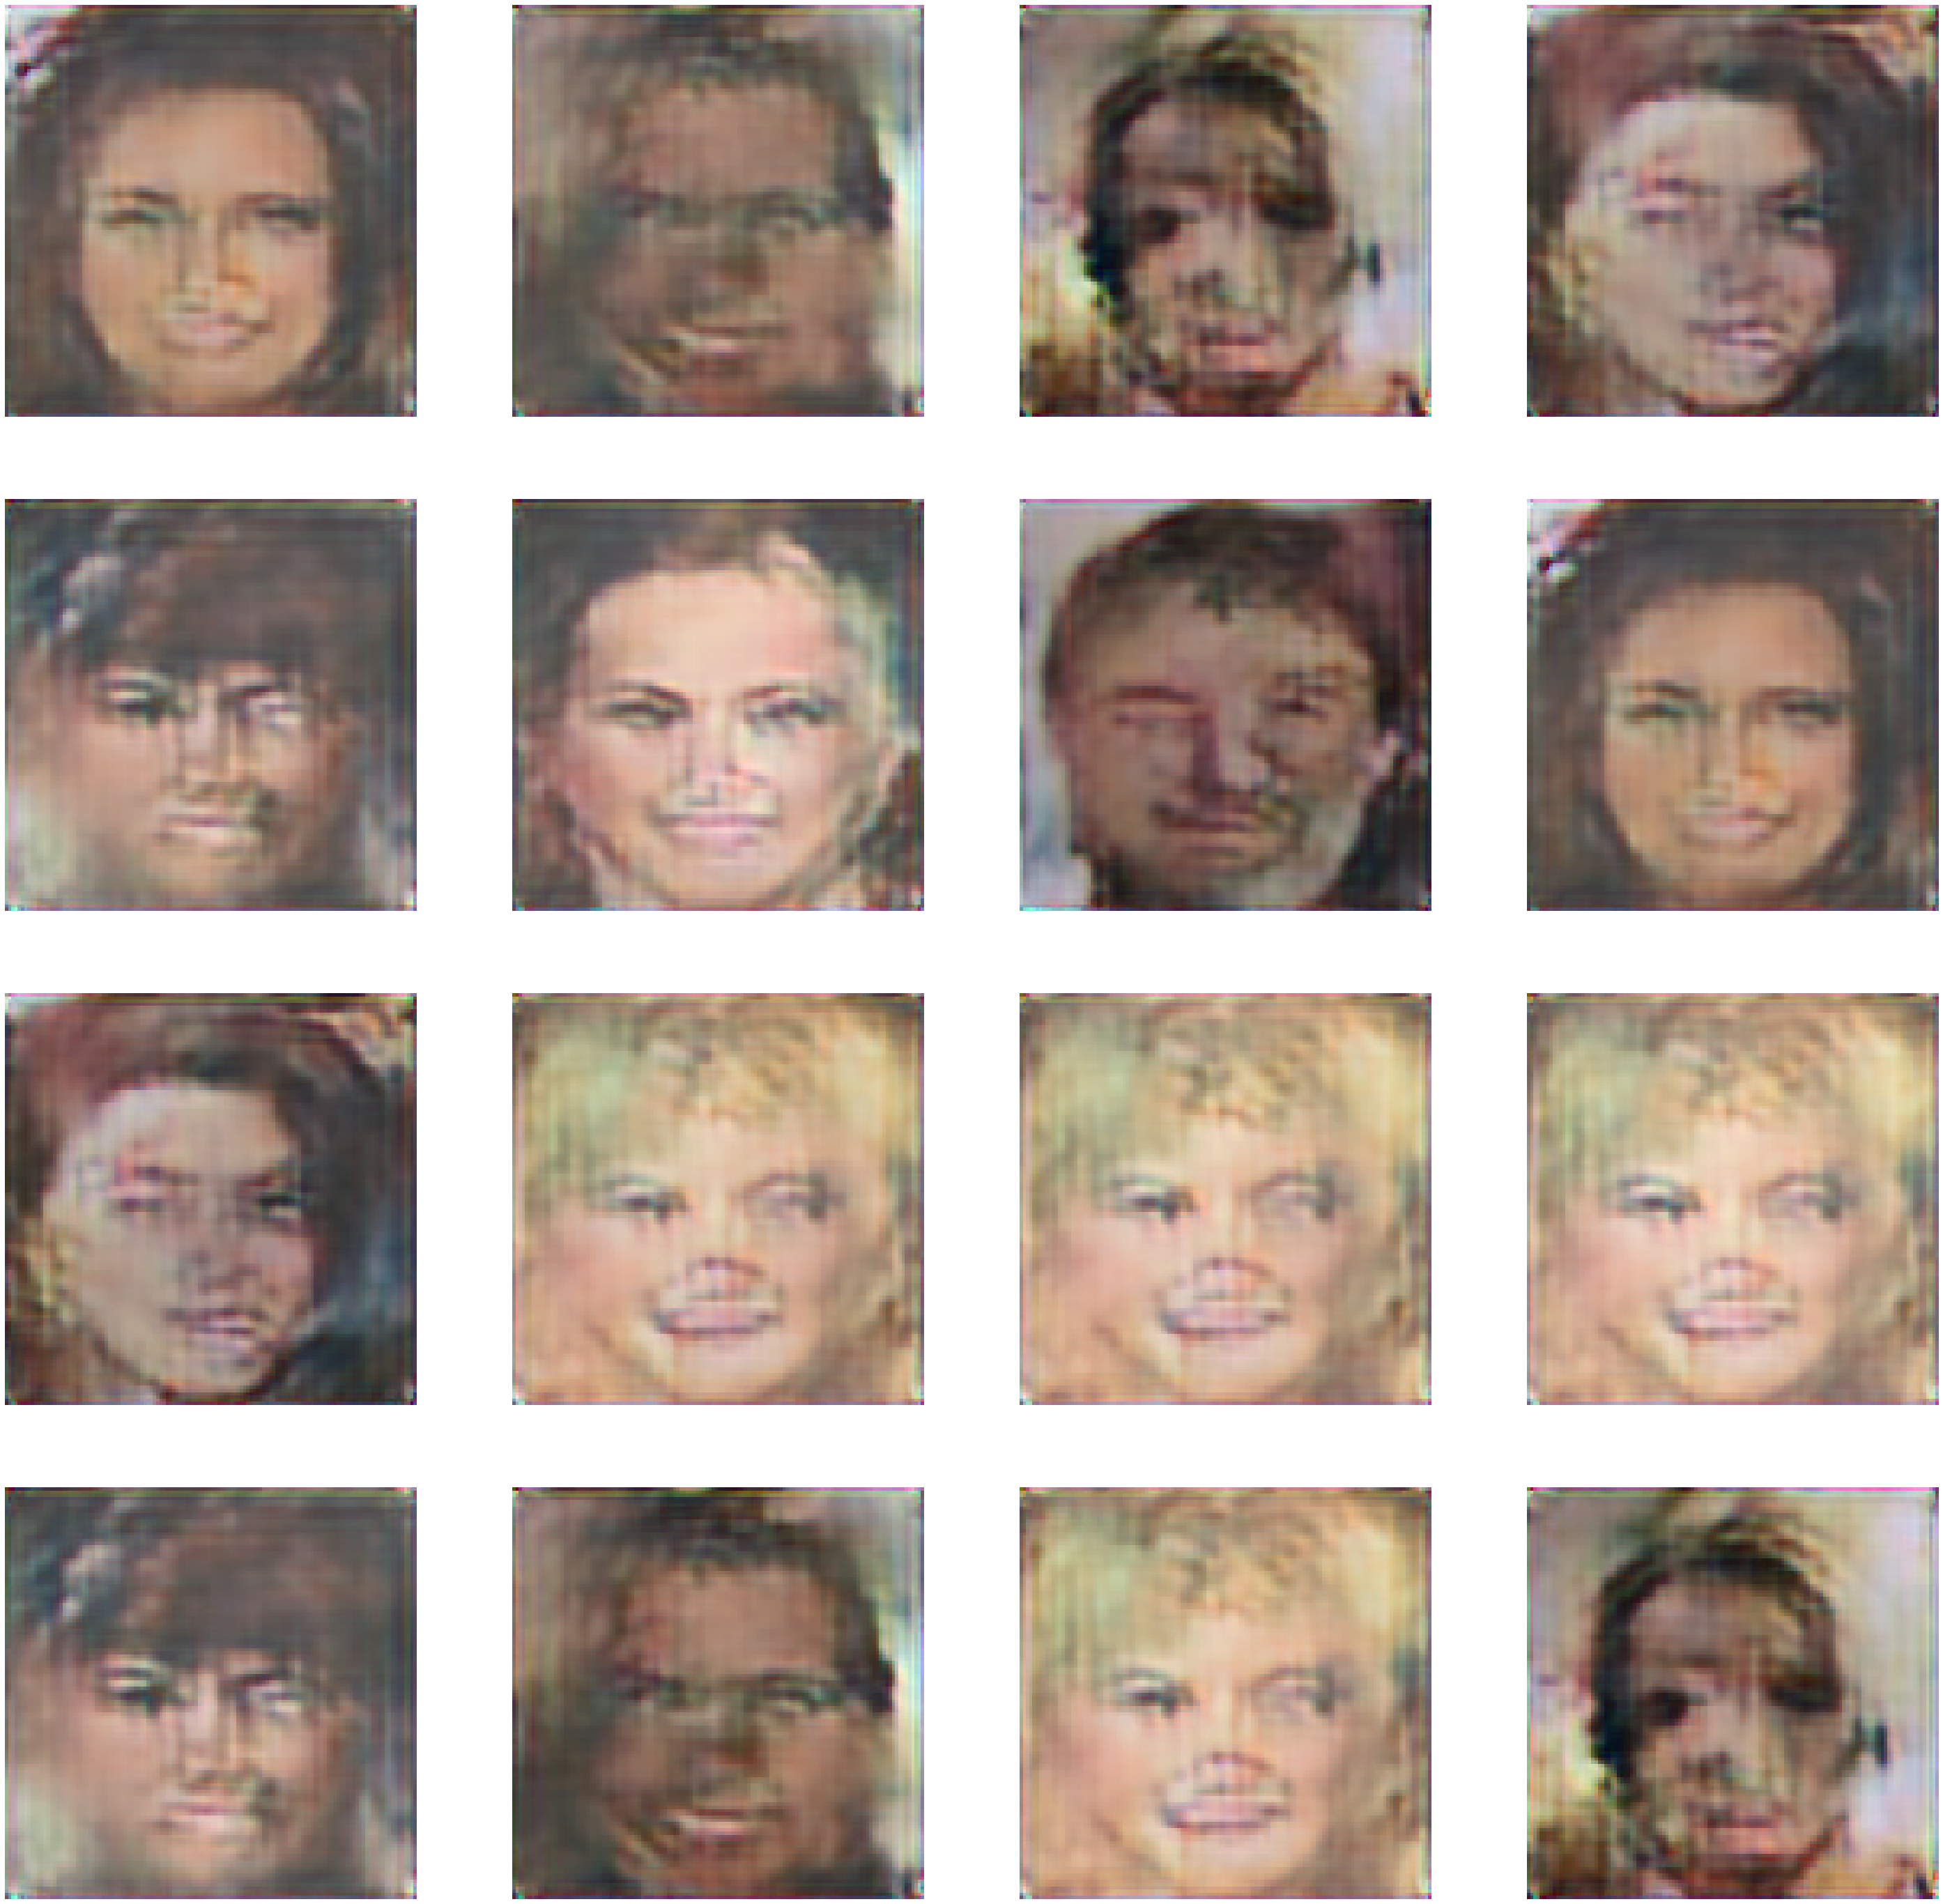

In [182]:
def normalize(image):
    return ((image-image.min())/(image.max()-image.min()))
fig, ax = plt.subplots(4,4, figsize=(50, 50))
ax = np.reshape(ax, 4*4)
xsim =  session.run(gen.xsim) #dis.sim_pyramid[-1].eval()
for i in range(4*4):
    image = (xsim[i][:,:,:]+1)*0.5
    ax[i].imshow(np.squeeze(normalize(image)),
                 interpolation='nearest')
    ax[i].axis('off')
plt.savefig('gen_image.pdf')

In [183]:
#model.embedding.components[0].loc.value().eval()

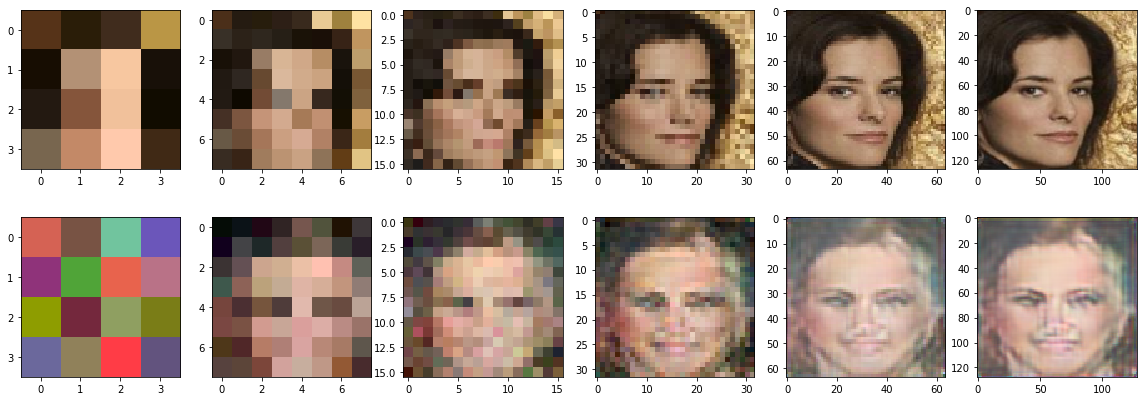

In [184]:
fig, ax = plt.subplots(2, len(dis.real_pyramid), figsize=(20, 7))
real_pyramid_ = session.run(dis.real_pyramid)
sim_pyramid_ = session.run(dis.sim_pyramid)
for idx in range(len(dis.real_pyramid)):
    ax[0, idx].imshow(np.squeeze(normalize(real_pyramid_[idx][1, ...])),
                      interpolation='nearest')
    ax[1, idx].imshow(np.squeeze(normalize(sim_pyramid_[idx][-1, ...])),
                      interpolation='nearest')